# Predict Baseball Strike Zones

In this project, we will use a Support Vector Machines, trained using a [`pybaseball`](https://github.com/jldbc/pybaseball) dataset, to find strike zones' decision boundary of players with different physical parameters. 

The strike zone can be thought of as a decision boundary itself, because it determines whether a pitch is a **"strike"** or a **"ball"**. There is a strict definition of the strike zone. A pitch is considered a "strike" if it passes through the strike zone (regardless if the batter swings at the pitch or not) and travels over home plate. A pitch is considered a "ball" if it does NOT pass through the strike zone and the batter does NOT swing at the pitch. However, in practice, it will vary depending on the umpire or the player at bat. Considering this, we'll use SVMs to find the real strike zone of specific baseball players. 

SVMs are machine learning models that can make complex decision boundaries and that's exactly what we need here. SVMs can twist and curve these boundaries to accommodate training data. As a result, our decision boundaries will be both informative and flexible. 

Let's start with necessary imports and data exploration.

## Exploring Data

In [110]:
# Basic imports related to analysis
import pandas as pd
import numpy as np

# Imports for visualisationin
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay

# Imports for ml
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# Data import
import pybaseball
from pybaseball import statcast
from pybaseball import playerid_lookup
from pybaseball import statcast_pitcher

# Imports for files processing
import os
import pickle

Note: we are going to use pickle to speed up running time, so in some cells will be placed pickle functions.

In [4]:
def pickle_object(object, file_path):
    with open(file_path, 'wb') as f:
        pickle.dump(object, f)

def unpickle_object(file_path):
    if not os.path.isfile(file_path):
        return None
    with open(file_path, 'rb') as f:
        return pickle.load(f)

def with_pickle(file_path, fun):
    value = unpickle_object(file_path)
    if value is None:
        value = fun()
        pickle_object(value, file_path)
    return value

We are going to use `pybaseball`'s `statcast` table filtered by `player_name` as a source of our data. According to documentation, the statcast function retrieves pitch-level statcast data for a given date or range or dates, so let's upload the slice of `statcast` from **01.01.22** till **13.09.22**. 

In [5]:
pybaseball.cache.enable()
stats = statcast(start_dt='2022-01-01', end_dt='2022-09-13')
stats.head()

This is a large query, it may take a moment to complete
Skipping offseason dates


100%|██████████| 183/183 [00:09<00:00, 18.65it/s]


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
3213,FF,2022-09-13,96.3,-2.25,4.6,"Kimbrel, Craig",572233,518886,field_out,hit_into_play,...,4,4,0,0,4,Infield shift,Standard,222,-0.001,-0.118
3299,FF,2022-09-13,95.7,-2.24,4.74,"Kimbrel, Craig",572233,518886,None,swinging_strike,...,4,4,0,0,4,Infield shift,Standard,219,0.0,-0.022
3428,KC,2022-09-13,85.4,-2.47,4.71,"Kimbrel, Craig",572233,518886,None,ball,...,4,4,0,0,4,Infield shift,Standard,62,0.0,0.023
3576,FF,2022-09-13,95.8,-2.31,4.81,"Kimbrel, Craig",572233,518886,None,ball,...,4,4,0,0,4,Infield shift,Standard,218,0.0,0.016
3600,FF,2022-09-13,95.9,-2.42,4.7,"Kimbrel, Craig",664983,518886,field_out,hit_into_play,...,4,4,0,0,4,Infield shift,Standard,223,-0.005,-0.137


Now let's find in this dataset, and filter out as separate variables, the data of one of the tallest (`Adam Wainwright`), one of the shortest (`Marcus Stroman`), and one of medium high (`Craig Kimbrel`) players. 

*The idea behind importing info depending on players' heights is that their strike zones should be different due to the difference in their physical parameters.*

In [6]:
pd.set_option('display.max_columns', None)
tallest = stats[stats.player_name == 'Wainwright, Adam']
tallest.head(3)

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
11,CU,2022-09-08,72.9,-1.01,6.46,"Wainwright, Adam",443558,425794,field_out,hit_into_play,<NA>,<NA>,<NA>,<NA>,5,"Nelson Cruz grounds out, second baseman Brenda...",R,R,R,STL,WSH,X,4,ground_ball,2,1,2022,1.31,-1.14,-0.24,2.55,572228,<NA>,660688,2,5,Top,125.83,162.84,<NA>,<NA>,425877,<NA>,<NA>,-0.711926,-106.080342,1.541132,10.002348,19.378541,-41.257468,3.55,1.61,2,86.2,-47,72.7,2853,6.3,661923,425794,425877,502671,680977,571448,669242,572816,641512,676475,54.18,0.109,0.103,0.0,1,0,0,2,46,4,Curveball,4,4,4,4,4,4,4,4,Standard,Standard,46,0.065,-0.495
16,CU,2022-09-08,73.5,-1.12,6.47,"Wainwright, Adam",443558,425794,None,called_strike,<NA>,<NA>,<NA>,<NA>,5,"Nelson Cruz grounds out, second baseman Brenda...",R,R,R,STL,WSH,S,<NA>,None,2,0,2022,1.3,-1.16,-0.27,2.7,572228,<NA>,660688,2,5,Top,<NA>,<NA>,<NA>,<NA>,425877,<NA>,<NA>,-0.53159,-107.043698,1.69381,10.058618,19.039135,-41.609866,3.6,1.69,<NA>,<NA>,<NA>,73.5,2896,6.3,661923,425794,425877,502671,680977,571448,669242,572816,641512,676475,54.16,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,46,3,Curveball,4,4,4,4,4,4,4,4,Standard,Standard,46,0.0,-0.099
21,SI,2022-09-08,87.7,-1.18,6.27,"Wainwright, Adam",443558,425794,None,ball,<NA>,<NA>,<NA>,<NA>,11,"Nelson Cruz grounds out, second baseman Brenda...",R,R,R,STL,WSH,B,<NA>,None,1,0,2022,-1.02,0.68,-1.8,3.36,572228,<NA>,660688,2,5,Top,<NA>,<NA>,<NA>,<NA>,425877,<NA>,<NA>,0.59574,-127.86136,-2.392356,-11.313075,24.481722,-24.382497,3.68,1.77,<NA>,<NA>,<NA>,88.5,2153,6.5,661923,425794,425877,502671,680977,571448,669242,572816,641512,676475,53.99,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,46,2,Sinker,4,4,4,4,4,4,4,4,Standard,Standard,204,0.0,0.049


In [7]:
shortest = stats[stats.player_name == 'Stroman, Marcus']
shortest.head(3)

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
262,FC,2022-09-10,87.6,-1.29,5.18,"Stroman, Marcus",573262,573186,strikeout,swinging_strike_blocked,<NA>,<NA>,<NA>,<NA>,13,Mike Yastrzemski strikes out swinging.,R,L,R,CHC,SF,S,2,None,2,2,2022,0.29,-0.21,-0.24,0.43,<NA>,663698,<NA>,2,4,Top,<NA>,<NA>,<NA>,<NA>,664731,<NA>,<NA>,1.927424,-127.662918,-5.008761,2.922169,21.746402,-33.831161,3.33,1.55,<NA>,<NA>,<NA>,87.8,2768,6.0,663127,573186,664731,663845,656716,623520,663538,664023,666624,673548,54.54,<NA>,<NA>,0.0,1,0,0,<NA>,33,7,Cutter,2,4,4,2,4,2,4,2,Infield shift,Standard,90,0.028,-0.261
280,FC,2022-09-10,89.7,-0.98,5.16,"Stroman, Marcus",573262,573186,None,foul,<NA>,<NA>,<NA>,<NA>,14,Mike Yastrzemski strikes out swinging.,R,L,R,CHC,SF,S,<NA>,None,2,2,2022,0.32,0.18,0.93,1.98,<NA>,663698,<NA>,2,4,Top,<NA>,<NA>,<NA>,<NA>,664731,<NA>,<NA>,4.040596,-130.822366,-2.36763,2.970212,22.993038,-29.885043,3.33,1.55,249,86.1,47,90.1,2783,6.1,663127,573186,664731,663845,656716,623520,663538,664023,666624,673548,54.45,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,33,6,Cutter,2,4,4,2,4,2,4,2,Infield shift,Standard,145,0.0,0.0
312,SI,2022-09-10,92.9,-0.85,5.09,"Stroman, Marcus",573262,573186,None,foul,<NA>,<NA>,<NA>,<NA>,5,Mike Yastrzemski strikes out swinging.,R,L,R,CHC,SF,S,<NA>,None,2,2,2022,-1.11,0.15,-0.02,2.46,<NA>,663698,<NA>,2,4,Top,<NA>,<NA>,<NA>,<NA>,664731,<NA>,<NA>,4.538102,-135.498268,-1.395041,-14.689253,23.758408,-30.228685,3.33,1.55,232,72.4,33,93.3,2361,6.0,663127,573186,664731,663845,656716,623520,663538,664023,666624,673548,54.51,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,33,5,Sinker,2,4,4,2,4,2,4,2,Infield shift,Standard,216,0.0,0.0


In [8]:
medium = stats[stats.player_name == 'Kimbrel, Craig']
medium.head(3)

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
3213,FF,2022-09-13,96.3,-2.25,4.6,"Kimbrel, Craig",572233,518886,field_out,hit_into_play,<NA>,<NA>,<NA>,<NA>,14,Christian Walker lines out to second baseman C...,R,R,R,ARI,LAD,X,4,line_drive,2,1,2022,-0.78,1.44,0.85,2.04,<NA>,<NA>,<NA>,2,9,Bot,127.91,134.48,<NA>,<NA>,669257,<NA>,<NA>,10.053696,-139.833164,-4.464915,-12.641847,33.898659,-12.483292,3.27,1.5,166,78.9,10,96.6,2371,6.8,663323,518886,669257,518692,621035,571970,607208,608336,641355,605141,53.75,0.38,0.342,0.0,1,0,0,4,74,4,4-Seam Fastball,0,4,0,4,4,0,0,4,Infield shift,Standard,222,-0.001,-0.118
3299,FF,2022-09-13,95.7,-2.24,4.74,"Kimbrel, Craig",572233,518886,None,swinging_strike,<NA>,<NA>,<NA>,<NA>,2,Christian Walker lines out to second baseman C...,R,R,R,ARI,LAD,S,<NA>,None,2,0,2022,-0.82,1.23,-0.19,2.99,<NA>,<NA>,<NA>,2,9,Bot,<NA>,<NA>,<NA>,<NA>,669257,<NA>,<NA>,7.294968,-139.173799,-1.753098,-12.352043,32.500733,-16.052742,3.27,1.5,<NA>,<NA>,<NA>,96.2,2311,6.7,663323,518886,669257,518692,621035,571970,607208,608336,641355,605141,53.78,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,74,3,4-Seam Fastball,0,4,0,4,4,0,0,4,Infield shift,Standard,219,0.0,-0.022
3428,KC,2022-09-13,85.4,-2.47,4.71,"Kimbrel, Craig",572233,518886,None,ball,<NA>,<NA>,<NA>,<NA>,14,Christian Walker lines out to second baseman C...,R,R,R,ARI,LAD,B,<NA>,None,1,0,2022,1.14,-0.72,0.33,0.27,<NA>,<NA>,<NA>,2,9,Bot,<NA>,<NA>,<NA>,<NA>,669257,<NA>,<NA>,4.342637,-124.207898,-2.6319,10.647541,28.247074,-39.219896,3.27,1.5,<NA>,<NA>,<NA>,85.5,2541,6.7,663323,518886,669257,518692,621035,571970,607208,608336,641355,605141,53.82,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,74,2,Knuckle Curve,0,4,0,4,4,0,0,4,Infield shift,Standard,62,0.0,0.023


In [9]:
stats.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estima

## Determining Features & Labels

There are a lot of columns in this dataset, we won't need all of them. We’re interested in looking at whether a pitch was a "ball" or a "strike". That information should be stored in the `type` column. Let's take a look at the unique values stored in it.

In [10]:
tallest.type.unique()

array(['X', 'S', 'B'], dtype=object)

The types should be the same for all players, either an `S` for a "strike", a `B` for a "ball", or an `X` for neither (for example, an `X` could be a hit or an out).

In [11]:
shortest.type.unique()

array(['S', 'B', 'X'], dtype=object)

We want to predict whether a pitch is a "ball" or a "strike" based on its location over the plate. We can find the "ball’s" location in the columns `plate_x` and `plate_z`. 

*`plate_x` measures how far left or right the pitch is from the center of home plate. If `plate_x = 0`, that means the pitch was directly in the middle of the home plate.*

*`plate_z` measures how high off the ground the pitch was. If `plate_z = 0`, that means the pitch was at ground level when it got to the home plate.*

Let's see what unique values these columns have.

In [12]:
tallest.plate_x.unique()

<FloatingArray>
[-0.24, -0.27,  -1.8,  1.99, -0.76,  0.18, -0.25,  1.24,  0.49,  0.89,
 ...
   1.5, -1.84, -2.13, -2.16, -1.65,  1.72, -1.57, -2.12, -1.77,  <NA>]
Length: 400, dtype: Float64

In [13]:
tallest.plate_z.unique()

<FloatingArray>
[ 2.55,   2.7,  3.36, -0.14,  3.78,  2.91,  2.17,  2.28,   3.1,  0.37,
 ...
  4.18,  0.71,  0.18,  4.74, -0.73,  -0.3,  4.22,  4.41,  0.03,  <NA>]
Length: 439, dtype: Float64

There can be seen some `NaN` values in `plates` data, we'll remove them on the next steps.

Now let's add two more features for our model to meditate on - the previous number of "strikes" and "balls" the batter already has. These data are contained within `strike` column. It also might have some impact on whether the next pitch is a "strike" or a "ball", because professional players have some pretty stable statistics of their key performance indicators.

In [14]:
tallest.strikes.unique(), shortest.strikes.unique(), medium.strikes.unique()

(<IntegerArray>
 [1, 0, 2]
 Length: 3, dtype: Int64,
 <IntegerArray>
 [2, 1, 0]
 Length: 3, dtype: Int64,
 <IntegerArray>
 [1, 0, 2]
 Length: 3, dtype: Int64)

We now have the five columns we want to work with: `plate_x`, `plate_z`, `strike`, `balls` and `type`. Let's remove all other columns from all three variables. 

In [15]:
tallest_feat = tallest[['type', 'plate_x', 'plate_z', 'strikes', 'balls']].reset_index(drop=True)
shortest_feat = shortest[['type', 'plate_x', 'plate_z', 'strikes', 'balls']].reset_index(drop=True)
medium_feat = medium[['type', 'plate_x', 'plate_z', 'strikes', 'balls']].reset_index(drop=True)

medium_feat.head()

,type,plate_x,plate_z,strikes,balls
0,X,0.85,2.04,1,2
1,S,-0.19,2.99,0,2
2,B,0.33,0.27,0,1
3,B,0.08,3.74,0,0
4,X,-0.74,3.54,2,2


We’ll want to use `type` feature values as labels for our data points. However, instead of using strings we'll change every `S` to a `1` and every `B` to a `0`, `X` will be left as `NaN` and we'll remove all such values on the next step.

In [16]:
tallest_feat.type = tallest_feat.type.map({'S':1, 'B':0})
shortest_feat.type = shortest_feat.type.map({'S':1, 'B':0})
medium_feat.type = medium_feat.type.map({'S':1, 'B':0})

tallest_feat.head()

,type,plate_x,plate_z,strikes,balls
0,NaN,-0.24,2.55,1,2
1,1.0,-0.27,2.7,0,2
2,0.0,-1.8,3.36,0,1
3,0.0,1.99,-0.14,0,0
4,NaN,-0.76,3.78,0,0


Let’s remove every row that has a `NaN` in any of those columns.

In [17]:
tallest_feat = tallest_feat.dropna(subset = ['type', 'plate_x', 'plate_z', 'strikes', 'balls'])
shortest_feat = shortest_feat.dropna(subset = ['type', 'plate_x', 'plate_z', 'strikes', 'balls'])
medium_feat = medium_feat.dropna(subset = ['type', 'plate_x', 'plate_z', 'strikes', 'balls'])
# Check if previously spottet NaNs in plate_z column are gone
tallest_feat.plate_z.unique()[-10:]

<FloatingArray>
[0.71, 1.19, 0.18, 4.74, -0.73, -0.3, 4.22, 4.41, 0.03, 3.21]
Length: 10, dtype: Float64

In [18]:
tallest_feat.head()

,type,plate_x,plate_z,strikes,balls
1,1.0,-0.27,2.7,0,2
2,0.0,-1.8,3.36,0,1
3,0.0,1.99,-0.14,0,0
6,1.0,-0.25,2.17,0,1
7,0.0,1.24,2.28,0,0


So, what our end data numbers? 

In [19]:
print('Adam Wainwright:', tallest_feat.shape)
print('Marcus Stroman:', shortest_feat.shape)
print('Craig Kimbrel:', medium_feat.shape)

Adam Wainwright: (2312, 5)
Marcus Stroman: (1480, 5)
Craig Kimbrel: (798, 5)


Craig Kimbrel has the least amount of data, but still enough to make some decent analysis with SVM. Let's check correlations of our labels with features visually.

<AxesSubplot:title={'center':"Adam Wainwright's Parameters Correlation"}>

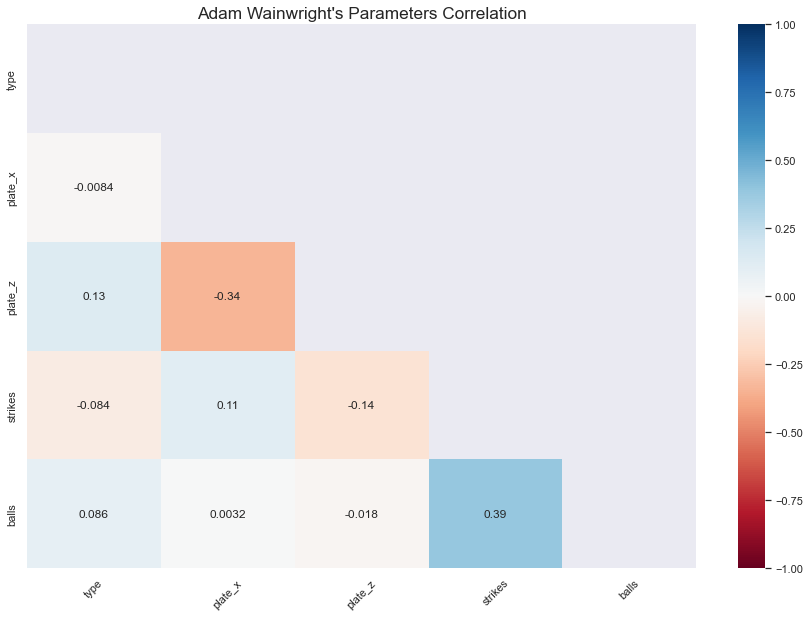

In [20]:
# Apply darkgrid to all plots 
sns.set(style='darkgrid')

def visualise_heatmap(dataset_corr, corr_objects, cmap):
    # Prepare figure
    plt.figure(figsize = (15,10))

    # Draw heatmap as triangle
    mask = np.triu(np.ones_like(dataset_corr, dtype=bool))
    # Add descriptions
    plt.title(corr_objects, fontsize= 'x-large')
    plt.xticks(rotation=45)

    # Plot heatmap
    heatmap = sns.heatmap(dataset_corr, annot=True, vmax=1, vmin=-1, cmap=cmap, mask=mask)
    return heatmap

visualise_heatmap(tallest_feat.corr(), 'Adam Wainwright\'s Parameters Correlation', cmap='RdBu')

<AxesSubplot:title={'center':"Marcus Stroman's Parameters Correlation"}>

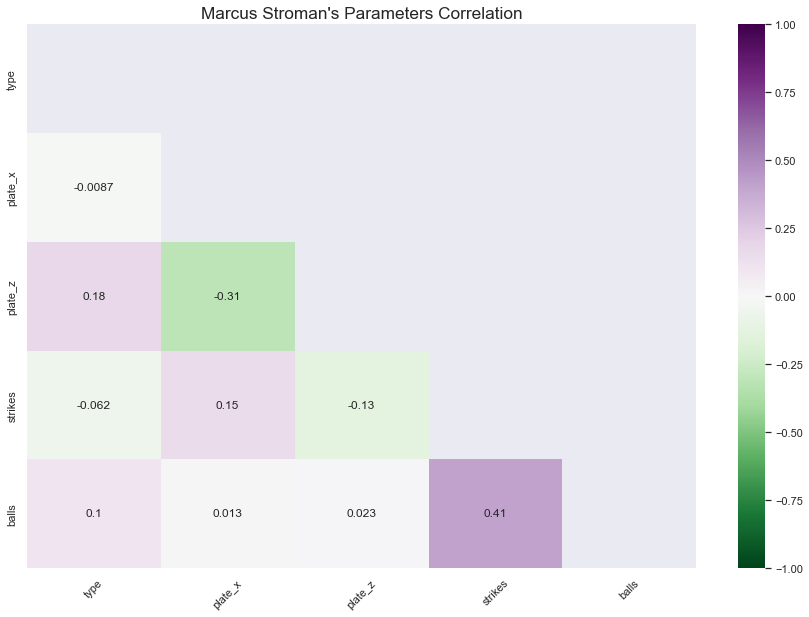

In [21]:
visualise_heatmap(shortest_feat.corr(), 'Marcus Stroman\'s Parameters Correlation', cmap='PRGn_r')

<AxesSubplot:title={'center':"Craig Kimbrel's Parameters Correlation"}>

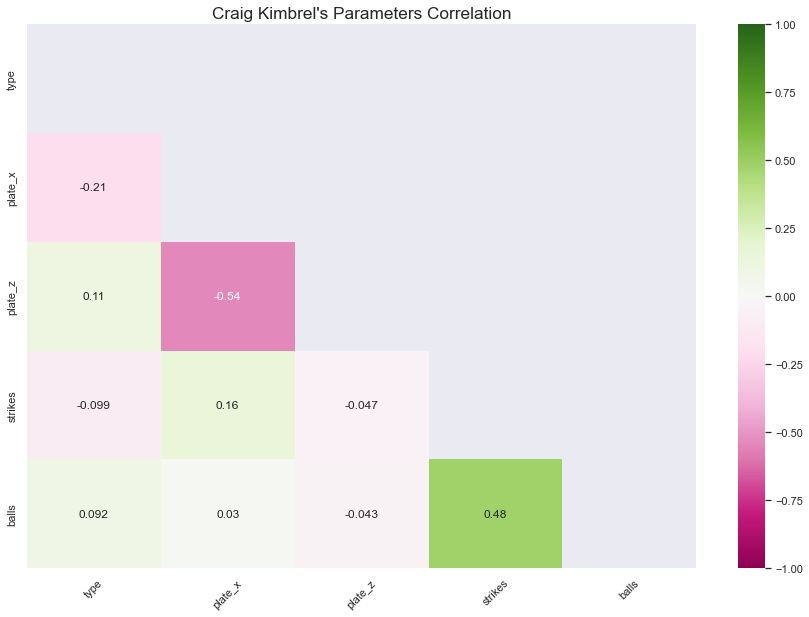

In [22]:
visualise_heatmap(medium_feat.corr(), 'Craig Kimbrel\'s Parameters Correlation', cmap='PiYG')

Results: 
- Most significant correlations are among 2 plates and "balls" and "strikes". 
- All correlations with `type` are very small - around `1-2`.

That's not good, but considering that "ball or strike" is a fundamentally random event with no definite cause only many circumstantial reasons, not too bad either. To find columns that have more significant correlation we should do more sophisticated in-depth analysis. 

## Plotting Pitches

Now let's plot "ball" and "strike" pithces of each player on separate graphs.  

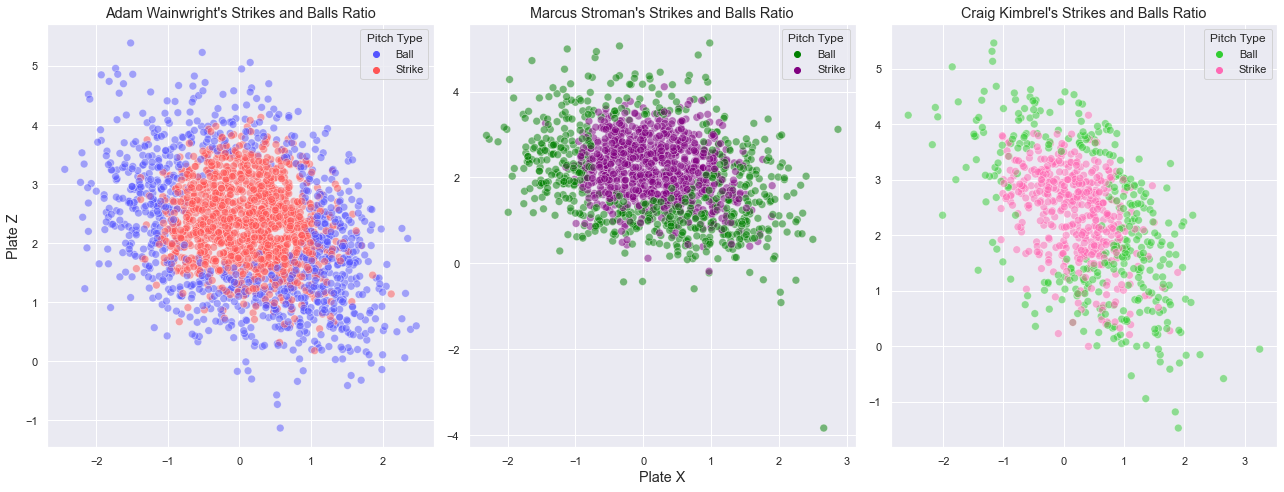

In [23]:
def scatter(dataset1, dataset2, dataset3, palette, name):
    # Set up layout
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,7))

    # Draw plots
    sns.scatterplot(x=dataset1.plate_x, y=dataset1.plate_z, hue=dataset1.type, palette=palette[0], alpha=0.5, legend=True, s=60, ax=ax1)
    sns.scatterplot(x=dataset2.plate_x, y=dataset2.plate_z, hue=dataset2.type, palette=palette[1], alpha=0.5, legend=True, s=60, ax=ax2)
    sns.scatterplot(x=dataset3.plate_x, y=dataset3.plate_z, hue=dataset3.type, palette=palette[2], alpha=0.5, legend=True, s=60, ax=ax3)

    # Set up titles
    ax1.set_title(name[0] + 'Strikes and Balls Ratio', fontsize='large')
    ax2.set_title(name[1] + 'Strikes and Balls Ratio', fontsize='large')
    ax3.set_title(name[2] + 'Strikes and Balls Ratio', fontsize='large')


    # Set up legends
    ax1.legend(title='Pitch Type')
    ax1.legend_.texts[0].set_text('Ball')
    ax1.legend_.texts[1].set_text('Strike')

    ax2.legend(title='Pitch Type')
    ax2.legend_.texts[0].set_text('Ball')
    ax2.legend_.texts[1].set_text('Strike')

    ax3.legend(title='Pitch Type')
    ax3.legend_.texts[0].set_text('Ball')
    ax3.legend_.texts[1].set_text('Strike')

    # Set up labels
    ax1.set_xlabel(None)
    ax2.set_xlabel('Plate X', fontsize='large')
    ax3.set_xlabel(None)

    ax1.set_ylabel('Plate Z', fontsize='large')
    ax2.set_ylabel(None)
    ax3.set_ylabel(None)

    fig.tight_layout()
    return plt.show()

scatter(
    tallest_feat, 
    shortest_feat, 
    medium_feat, 
    palette=['seismic', ['Green', 'Purple'], ['LimeGreen', 'HotPink']], 
    name=['Adam Wainwright\'s ', 'Marcus Stroman\'s ', 'Craig Kimbrel\'s '])

Results:

So if we recall how the plates are used in a game: 

*`plate_x` measures how far left or right the pitch is from the center of home plate. If `plate_x = 0`, that means the pitch was directly in the middle of the home plate.*

*`plate_z` measures how high off the ground the pitch was. If `plate_z = 0`, that means the pitch was at ground level when it got to the home plate.*

There can be seen on the graphs 2 main tendencies: 
- "Strikes" are located in one big cluster that is spread from player to player in different directions;
- "Balls" generally create an oval area around "strikes". It is less obvious on the Craig Kimbrel's graph, but still noticeable even though his dataset has a lot less data. 
- All "balls" tend to spread from the left upper corner to the right lower, especially when it comes to higher players. It is, most likely, conditioned by the specific posture and player's motion model required by the game, but we can clearly see that height plays a big role in it too.

If we look at the graphs of each player closely we could notice the following "personal" tendencies:
- Adam Wainwright being one of the tallest players covers a lot more area dedicated to "balls", but at the same has pretty big cluster of "strikes" in the middle.
- Marcus Stroman's results are spread more horizontally than vertically and their heights are one meter lower in general - at the level of 4 meters. 
- Craig Kimbrel has fewer data but his pattern more or less similar to Adam Wainwright's.

## Building SVMs

Now that we’ve seen the location of every pitch, let’s train SVMs to create a decision boundary. There will be 6 SVMs in total that we'll be able to compare in turms of scores. Each player will have 2 SVMs - one trained on 2 features (`plate_x` and `plate_z`), the other on 4 features (`plate_x`, `plate_z`, `strikes`, `balls`). The decision boundary will be the real strike zone of each player. Additionally, SVMs trained on 2 features will be used to make 3 new 2D plots with decision boundaries visible on them. 

To begin, we want to validate our model, so we need to split the data into a training set and a validation set.

In [24]:
training_set1, validation_set1 = train_test_split(tallest_feat, random_state = 1) 
training_set2, validation_set2 = train_test_split(shortest_feat, random_state = 2) 
training_set3, validation_set3 = train_test_split(medium_feat, random_state = 3) 

Now find best possible values for `C` and `gamma` parameters of our SVMs.

In [84]:
def highest_score(training_set, validation_set, features):
    best_score = 0
    best_gamma = 0
    best_c = 0
    best_classifier = None
    for current_gamma in np.arange(0.1, 101, 1):
        for current_c in np.arange(0.1, 101, 1):
            current_classifier = SVC(gamma=current_gamma, C=current_c)
            current_classifier.fit(training_set[features], training_set.type)
            current_score = current_classifier.score(validation_set[features], validation_set.type)
            if best_score < current_score:
                # print("found a better gamma, c", current_gamma, current_c, current_score)
                best_score = current_score
                best_gamma = current_gamma
                best_c = current_c
                best_classifier = current_classifier
    return best_score, best_gamma, best_c, best_classifier

Let's start with training classifiers on 2 features.

In [85]:
score1_2f, gamma1_2f, c1_2f, classifier1_2f = with_pickle('pickles/tallest_2f.pickle', lambda : highest_score(training_set1, validation_set1, features = ['plate_x', 'plate_z']))
score2_2f, gamma2_2f, c2_2f, classifier2_2f = with_pickle('pickles/shortest_2f.pickle', lambda : highest_score(training_set2, validation_set2, features = ['plate_x', 'plate_z']))
score3_2f, gamma3_2f, c3_2f, classifier3_2f = with_pickle('pickles/medium_2f.pickle', lambda : highest_score(training_set3, validation_set3, features = ['plate_x', 'plate_z']))

In [81]:
print('Adam Wainwright model\'s score, gamma and C with 2 features: ', score1_2f, gamma1_2f, c1_2f)
print('Same for Marcus Stroman model: ', score2_2f, gamma2_2f, c2_2f)
print('Same for Craig Kimbrel model: ', score3_2f, gamma3_2f, c3_2f)

Adam Wainwright model's score, gamma and C with 2 features:  0.8615916955017301 6.1 17.1
Same for Marcus Stroman model:  0.8243243243243243 1.1 0.1
Same for Craig Kimbrel model:  0.885 15.1 0.1


Here go classifiers trained on 4 features.

In [86]:
score1_4f, gamma1_4f, c1_4f, classifier1_4f = with_pickle('pickles/tallest_4f.pickle', lambda : highest_score(training_set1, validation_set1, features = ['plate_x', 'plate_z', 'strikes', 'balls']))
score2_4f, gamma2_4f, c2_4f, classifier2_4f = with_pickle('pickles/shortest_4f.pickle', lambda : highest_score(training_set2, validation_set2, features = ['plate_x', 'plate_z', 'strikes', 'balls']))
score3_4f, gamma3_4f, c3_4f, classifier3_4f = with_pickle('pickles/medium_4f.pickle', lambda : highest_score(training_set3, validation_set3, features = ['plate_x', 'plate_z', 'strikes', 'balls']))

In [83]:
print('Adam Wainwright model\'s score, gamma and C with 4 features: ', score1_4f, gamma1_4f, c1_4f)
print('Same for Marcus Stroman model: ', score2_4f, gamma2_4f, c2_4f)
print('Same for Craig Kimbrel model: ', score3_4f, gamma3_4f, c3_4f)

Adam Wainwright model's score, gamma and C with 4 features:  0.8633217993079585 0.1 31.1
Same for Marcus Stroman model:  0.8378378378378378 4.1 2.1
Same for Craig Kimbrel model:  0.87 0.1 65.1


Results: the difference between scores of classifiers with 2 and 4 features are around 1%, so it is safe to say that such features as number of "strikes" and "balls" don't contribute much to the overall accuracy of the current SVMs. 

## Plotting Pitches with Decision Boundaries

Let's finally see how decision boundaries of current "2-features" classifiers look like on graphs. 

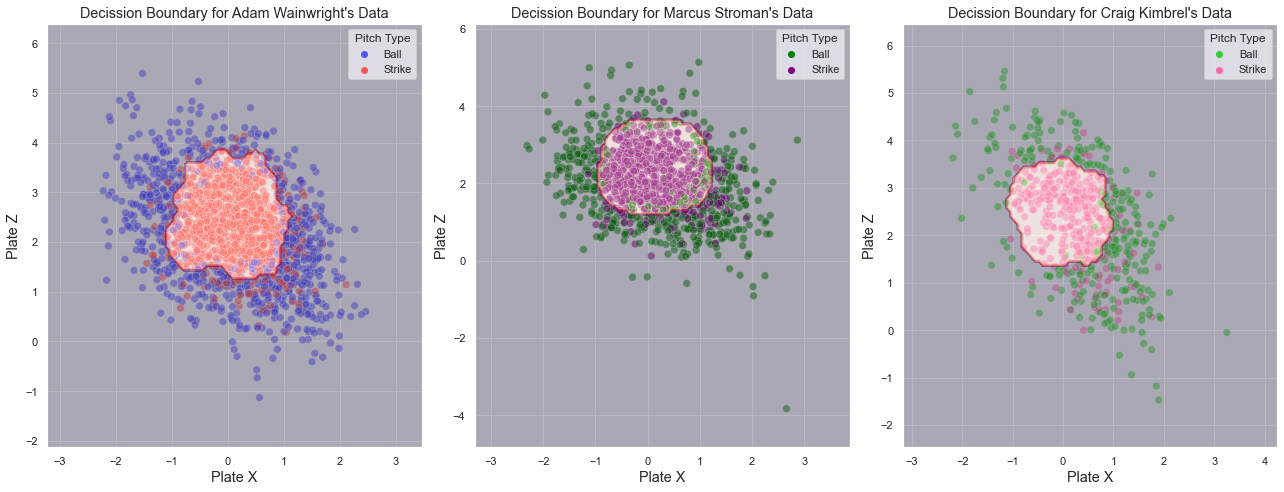

In [103]:
def scatter_des_boundaries(models, sets, palette, titles):
    # Set up grid for plotting.
    fig, sub = plt.subplots(1, 3, figsize=(18,7))
    # Draw scatterplots
    for clf, data_set, title, ax, colors in zip(models, sets, titles, sub.flatten(), palette):
        sns.scatterplot(x=data_set.plate_x, y=data_set.plate_z, hue=data_set.type, palette=colors, alpha=0.5, legend=True, s=60, ax=ax)
        # Draw decision boundaries
        disp = DecisionBoundaryDisplay.from_estimator(
            clf,
            data_set[['plate_x', 'plate_z']],
            response_method="predict",
            alpha=0.3,
            ax=ax,
            xlabel='Plate X',
            ylabel='Plate Z',
        )

        # Set up labels
        ax.set_title(title, fontsize='large')
        ax.set_xlabel('Plate X', fontsize='large')
        ax.set_ylabel('Plate Z', fontsize='large')

        # Set up legends
        ax.legend(title='Pitch Type')
        ax.legend_.texts[0].set_text('Ball')
        ax.legend_.texts[1].set_text('Strike')

    fig.tight_layout()

    return plt.show()

scatter_des_boundaries(
    # models for plots
    models = (
        classifier1_2f,
        classifier2_2f,
        classifier3_2f
        ),
    # data for plots    
    sets = (
        training_set1,
        training_set2,
        training_set3
        ),
    # colors for plots    
    palette = [
        'seismic', 
        ['Green', 'Purple'], 
        ['LimeGreen', 'HotPink']
        ],
    # title for the plots
    titles = (
        'Decission Boundary for Adam Wainwright\'s Data',
        'Decission Boundary for Marcus Stroman\'s Data',
        'Decission Boundary for Craig Kimbrel\'s Data'
    )
)

## Conclusion

We have created 6 SVMs based on the data of 3 players who has different heights. As expected their strike zones, as well as the decision boundaries based on their data, were different: 

- Tall (Adam Wainwright) and medium height (Craig Kimbrel) players have similar pattern of "balls" with cluster of "strikes" in the middle of it, spread from high left to the low right corner of the graph. 
- In general, the "strike" clusters of taller players take more space than the one of the short player. 
- Short player (Marcus Stroma) has also clusters of ball pitches with "strikes" in the middle, but it is spread more horizontally and located generally 1 meter lower than the others'. 
- Considering, that there is only one clear cluster of each type on each graph - all decision boundaries have similar circular forms and located around the area of maximum concentration of strike pitches. 